<a href="https://colab.research.google.com/github/sonjoy2074/CSE4531-Project/blob/main/Federated_Learning/Client_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import models
!pip install timm
import timm
from timm.loss import LabelSmoothingCrossEntropy
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import copy

In [ ]:
def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir)
    return all_data.classes

In [ ]:
def get_data_loaders(data_dir, batch_size, train=True):
    if train:
        transform = T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
            T.RandomApply(torch.nn.ModuleList([T.ColorJitter()]), p=0.25),
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize(timm.data.IMAGENET_DEFAULT_MEAN, timm.data.IMAGENET_DEFAULT_STD),
            T.RandomErasing(p=0.1, value='random')
        ])
        train_data = datasets.ImageFolder(os.path.join(data_dir, "Training/"), transform=transform)
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return train_loader, len(train_data)
    else:
        transform = T.Compose([
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize(timm.data.IMAGENET_DEFAULT_MEAN, timm.data.IMAGENET_DEFAULT_STD)
        ])
        test_data = datasets.ImageFolder(os.path.join(data_dir, "Testing/"), transform=transform)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return test_loader, len(test_data)


In [ ]:
dataset_path = "/content/drive/MyDrive/Sonjoy_dataset/User1_Brain_Mri_Images"
(train_loader, train_data_len) = get_data_loaders(dataset_path, 128, train=True)
test_loader, test_data_len = get_data_loaders(dataset_path, 32, train=False)

classes = get_classes("/content/drive/MyDrive/Sonjoy_dataset/User1_Brain_Mri_Images/Training")
print(classes, len(classes))


['glioma', 'meningioma', 'notumor', 'pituitary'] 4


In [ ]:
dataloaders = {
    "train": train_loader
}

dataset_sizes = {
    "train": train_data_len
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
from transformers import ViTImageProcessor, ViTForImageClassification
from PIL import Image
import requests

In [ ]:
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')


In [ ]:
for param in model.parameters():
    param.requires_grad = False

# Modify the classifier for ViT model
n_inputs = model.classifier.in_features  # Accessing the in_features of the last layer in classifier
model.classifier = nn.Sequential(
    nn.Linear(n_inputs, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, len(classes))
)


model = model.to(device)
print(model.classifier)


Sequential(
  (0): Linear(in_features=768, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=512, out_features=4, bias=True)
)


In [ ]:
criterion = LabelSmoothingCrossEntropy()
criterion = criterion.to(device)

# Optimizer
optimizer = optim.AdamW(model.classifier.parameters(), lr=0.001)

# Learning rate scheduler
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_losses = []
    train_accs = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs.logits, 1)
                    loss = criterion(outputs.logits, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            train_losses.append(epoch_loss)
            train_accs.append(epoch_acc)

            if phase == 'train' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Best val Acc: {best_acc:4f}')
    model.load_state_dict(best_model_wts)

    history = {
        'train_loss': train_losses,
        'train_acc': train_accs
    }

    return model, history

#model_ft, history = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=10)


In [ ]:
model_ft, history = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=20)
test_loss = 0.0
class_correct = list(0 for i in range(len(classes)))
class_total = list(0 for i in range(len(classes)))
model_ft.eval()

Epoch 0/19
----------


100%|██████████| 32/32 [02:47<00:00,  5.24s/it]


train Loss: 0.8263 Acc: 0.7469
Epoch 1/19
----------


100%|██████████| 32/32 [00:47<00:00,  1.49s/it]


train Loss: 0.6022 Acc: 0.8816
Epoch 2/19
----------


100%|██████████| 32/32 [00:47<00:00,  1.48s/it]


train Loss: 0.5678 Acc: 0.8993
Epoch 3/19
----------


100%|██████████| 32/32 [00:48<00:00,  1.53s/it]


train Loss: 0.5367 Acc: 0.9176
Epoch 4/19
----------


100%|██████████| 32/32 [00:47<00:00,  1.49s/it]


train Loss: 0.5242 Acc: 0.9275
Epoch 5/19
----------


100%|██████████| 32/32 [00:46<00:00,  1.46s/it]


train Loss: 0.5180 Acc: 0.9288
Epoch 6/19
----------


100%|██████████| 32/32 [00:49<00:00,  1.53s/it]


train Loss: 0.4961 Acc: 0.9407
Epoch 7/19
----------


100%|██████████| 32/32 [00:47<00:00,  1.48s/it]


train Loss: 0.4931 Acc: 0.9409
Epoch 8/19
----------


100%|██████████| 32/32 [00:47<00:00,  1.47s/it]


train Loss: 0.4824 Acc: 0.9509
Epoch 9/19
----------


100%|██████████| 32/32 [00:48<00:00,  1.53s/it]


train Loss: 0.4746 Acc: 0.9541
Epoch 10/19
----------


100%|██████████| 32/32 [00:47<00:00,  1.48s/it]


train Loss: 0.4692 Acc: 0.9583
Epoch 11/19
----------


100%|██████████| 32/32 [00:50<00:00,  1.57s/it]


train Loss: 0.4614 Acc: 0.9620
Epoch 12/19
----------


100%|██████████| 32/32 [00:53<00:00,  1.67s/it]


train Loss: 0.4607 Acc: 0.9655
Epoch 13/19
----------


100%|██████████| 32/32 [00:49<00:00,  1.54s/it]


train Loss: 0.4593 Acc: 0.9603
Epoch 14/19
----------


100%|██████████| 32/32 [00:48<00:00,  1.50s/it]


train Loss: 0.4560 Acc: 0.9667
Epoch 15/19
----------


100%|██████████| 32/32 [00:47<00:00,  1.49s/it]


train Loss: 0.4476 Acc: 0.9697
Epoch 16/19
----------


100%|██████████| 32/32 [00:50<00:00,  1.57s/it]


train Loss: 0.4436 Acc: 0.9732
Epoch 17/19
----------


100%|██████████| 32/32 [00:48<00:00,  1.52s/it]


train Loss: 0.4444 Acc: 0.9732
Epoch 18/19
----------


100%|██████████| 32/32 [00:47<00:00,  1.49s/it]


train Loss: 0.4444 Acc: 0.9722
Epoch 19/19
----------


100%|██████████| 32/32 [00:49<00:00,  1.54s/it]

train Loss: 0.4383 Acc: 0.9754
Best val Acc: 0.975434


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [ ]:
# Save the model
torch.save({
    'model_state_dict': model_ft.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': exp_lr_scheduler.state_dict(),
    'history': history,
    'classes': classes
}, '/content/drive/MyDrive/Models/doctor_1.pth')


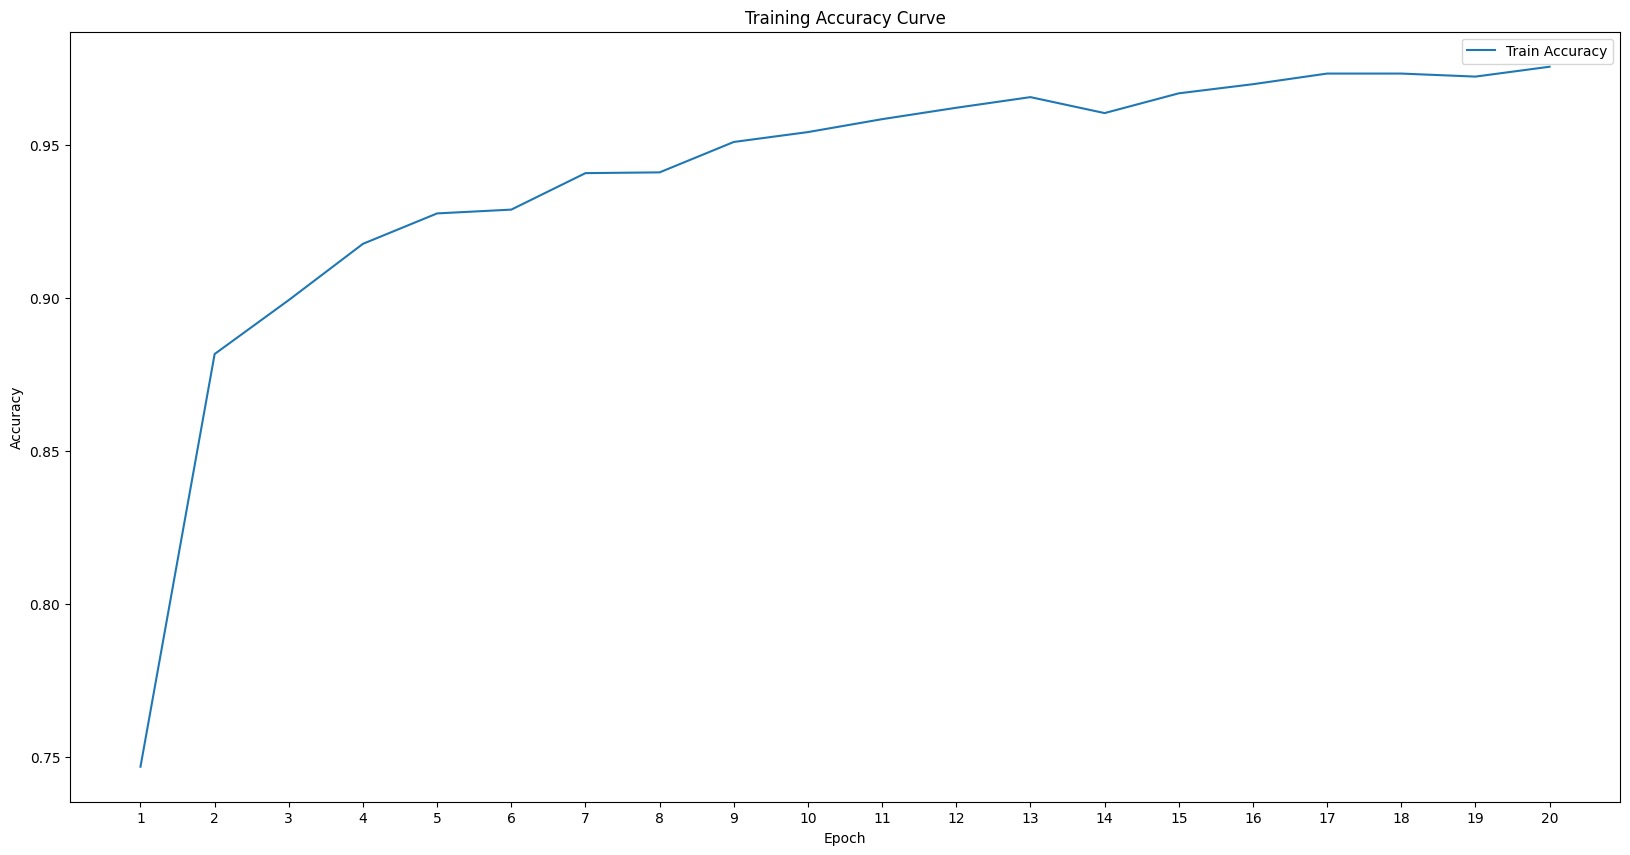

In [ ]:
num_epochs = 20
# Plotting the training accuracy
plt.figure(figsize=(20, 10))
plt.title("Training Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(range(1, num_epochs + 1), [acc.item() for acc in history['train_acc']], label='Train Accuracy')
plt.xticks(range(1, num_epochs + 1))
plt.legend()
plt.show()


#Test Local Model

In [ ]:
for data, target in tqdm(test_loader):
    data, target = data.to(device), target.to(device)
    with torch.no_grad():
        output = model_ft(data)
        loss = criterion(output.logits, target)  # Use logits to compute the loss
    test_loss += loss.item() * data.size(0)
    _, pred = torch.max(output.logits, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    if len(target) == 32:
        for i in range(32):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

test_loss = test_loss / test_data_len
print('Test Loss: {:.4f}'.format(test_loss))
for i in range(len(classes)):
    if class_total[i] > 0:
        print("Test Accuracy of %5s: %2d%% (%2d/%2d)" % (
            classes[i], 100 * class_correct[i] / class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])
        ))
    else:
        print("Test accuracy of %5s: NA" % (classes[i]))
print("Test Accuracy of %2d%% (%2d/%2d)" % (
    100 * np.sum(class_correct) / np.sum(class_total), np.sum(class_correct), np.sum(class_total)
))


100%|██████████| 32/32 [01:27<00:00,  2.73s/it]

Test Loss: 0.5030
Test Accuracy of glioma: 90% (223/246)
Test Accuracy of meningioma: 89% (224/251)
Test Accuracy of notumor: 97% (241/246)
Test Accuracy of pituitary: 94% (236/249)
Test Accuracy of 93% (924/992)


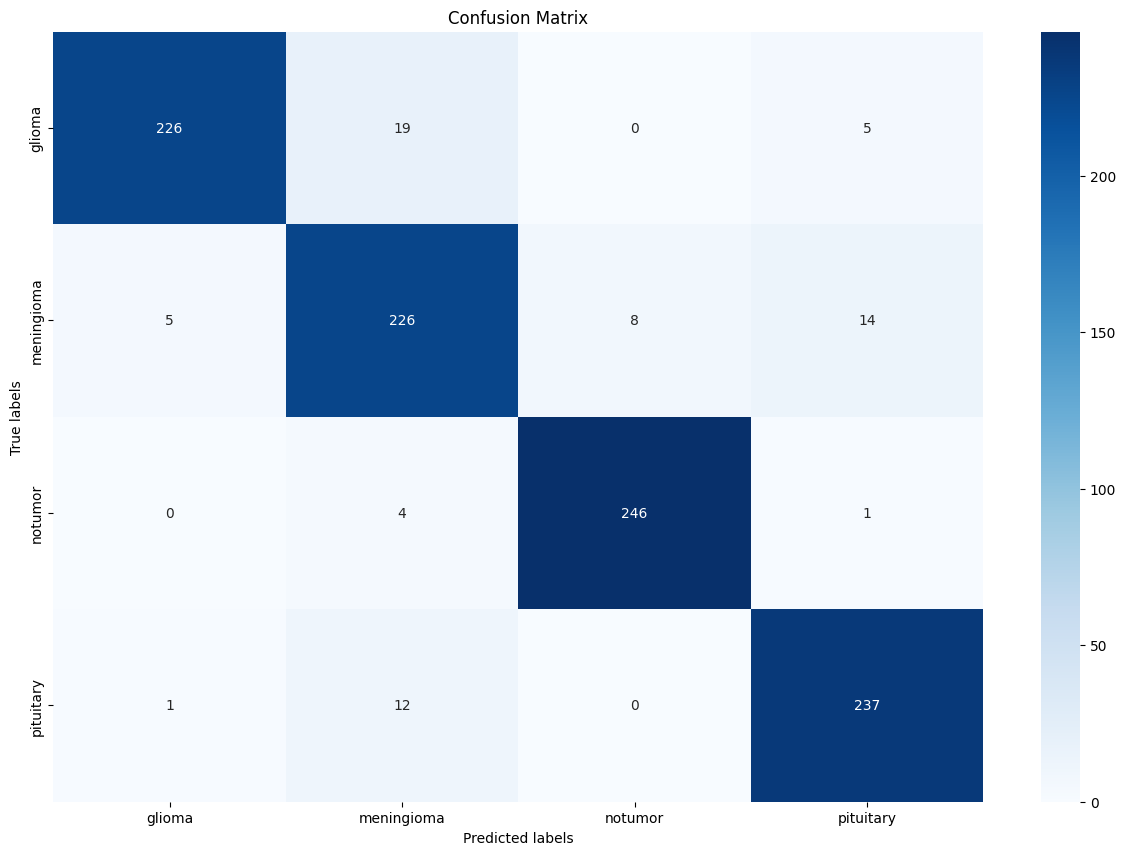

Classification Report:
              precision    recall  f1-score   support

      glioma       0.97      0.90      0.94       250
  meningioma       0.87      0.89      0.88       253
     notumor       0.97      0.98      0.97       251
   pituitary       0.92      0.95      0.93       250

    accuracy                           0.93      1004
   macro avg       0.93      0.93      0.93      1004
weighted avg       0.93      0.93      0.93      1004

Class: glioma
  Precision: 0.9741
  Recall:    0.9040
  F1 Score:  0.9378
--------------------
Class: meningioma
  Precision: 0.8659
  Recall:    0.8933
  F1 Score:  0.8794
--------------------
Class: notumor
  Precision: 0.9685
  Recall:    0.9801
  F1 Score:  0.9743
--------------------
Class: pituitary
  Precision: 0.9222
  Recall:    0.9480
  F1 Score:  0.9349
--------------------
Overall Metrics:
  Overall Precision: 0.9325
  Overall Recall:    0.9313
  Overall F1 Score:  0.9315


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score

# Set the model to evaluation mode
model.eval()

# Lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate over the test dataset
for inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Forward pass
    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs.logits, 1)  # Extract logits and apply torch.max()

    # Append true and predicted labels to lists
    true_labels.extend(labels.cpu().numpy())
    predicted_labels.extend(preds.cpu().numpy())

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Compute classification report
class_names = classes  # Your list of class names
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print("Classification Report:")
print(report)

# Compute precision, recall, and F1 score for each class
precision = precision_score(true_labels, predicted_labels, average=None)
recall = recall_score(true_labels, predicted_labels, average=None)
f1 = f1_score(true_labels, predicted_labels, average=None)

for i, cls in enumerate(class_names):
    print(f"Class: {cls}")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall:    {recall[i]:.4f}")
    print(f"  F1 Score:  {f1[i]:.4f}")
    print("-" * 20)

# Compute overall precision, recall, and F1 score
overall_precision = precision_score(true_labels, predicted_labels, average='weighted')
overall_recall = recall_score(true_labels, predicted_labels, average='weighted')
overall_f1 = f1_score(true_labels, predicted_labels, average='weighted')

print("Overall Metrics:")
print(f"  Overall Precision: {overall_precision:.4f}")
print(f"  Overall Recall:    {overall_recall:.4f}")
print(f"  Overall F1 Score:  {overall_f1:.4f}")


#Test Global Model

In [1]:
import torch
from transformers import ViTForImageClassification
import torch.nn as nn

# Load the global model
global_model_checkpoint = torch.load('/content/drive/MyDrive/Models/global_model_2.pth')

# Initialize the model architecture
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
n_inputs = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(n_inputs, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, len(global_model_checkpoint['classes']))
)

# Load the global model weights
model.load_state_dict(global_model_checkpoint['model_state_dict'])
model.eval()
model.to('cuda' if torch.cuda.is_available() else 'cpu')

classes = global_model_checkpoint['classes']



<ipython-input-1-a8ba67d08e7a>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  global_model_checkpoint = torch.load('/content/drive/MyDrive/Models/global_model_2.pth')
/usr

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [2]:
def get_data_loaders(data_dir, batch_size, train=True):
    if train:
        transform = T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
            T.RandomApply(torch.nn.ModuleList([T.ColorJitter()]), p=0.25),
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize(timm.data.IMAGENET_DEFAULT_MEAN, timm.data.IMAGENET_DEFAULT_STD),
            T.RandomErasing(p=0.1, value='random')
        ])
        train_data = datasets.ImageFolder(os.path.join(data_dir, "Training/"), transform=transform)
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return train_loader, len(train_data)
    else:
        transform = T.Compose([
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize(timm.data.IMAGENET_DEFAULT_MEAN, timm.data.IMAGENET_DEFAULT_STD)
        ])
        test_data = datasets.ImageFolder(os.path.join(data_dir, "Testing/"), transform=transform)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return test_loader, len(test_data)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Test Accuracy: 93.23%


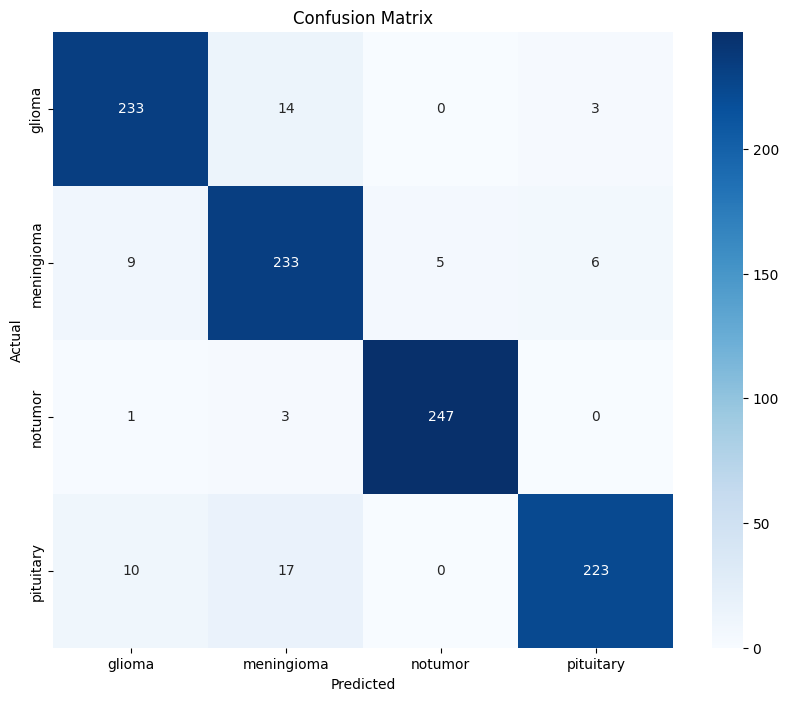

Classification Report:

              precision    recall  f1-score   support

      glioma       0.92      0.93      0.93       250
  meningioma       0.87      0.92      0.90       253
     notumor       0.98      0.98      0.98       251
   pituitary       0.96      0.89      0.93       250

    accuracy                           0.93      1004
   macro avg       0.93      0.93      0.93      1004
weighted avg       0.93      0.93      0.93      1004



In [3]:

from torchvision import transforms as T
from torchvision import datasets
!pip install timm
import timm
import os
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

dataset_path = "/content/drive/MyDrive/Sonjoy_dataset/User1_Brain_Mri_Images"

test_loader, test_data_len = get_data_loaders(dataset_path, 32, train=False)


def evaluate_model(model, test_loader, classes):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs.logits, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Detailed classification report
    print("Classification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=classes))

# Call the evaluation function
evaluate_model(model, test_loader, classes)
